## Modules

In [136]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [137]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [138]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [139]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [140]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [141]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [142]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [143]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [144]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


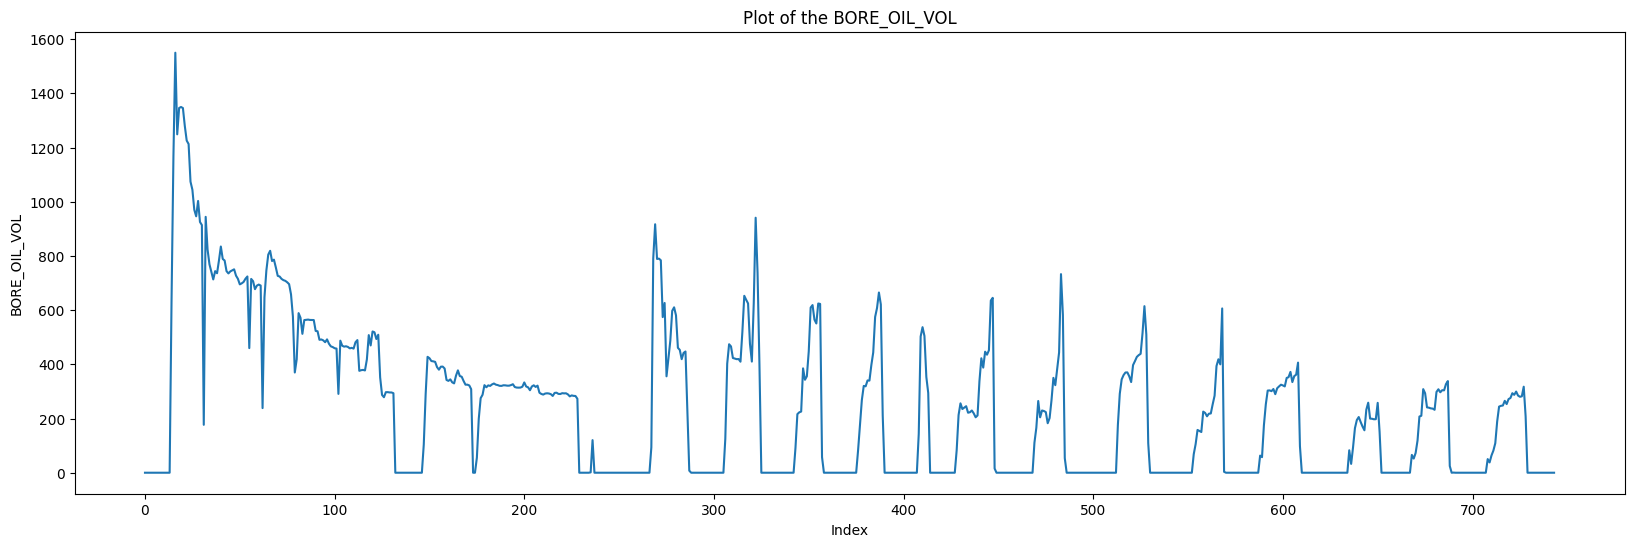

In [145]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [146]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [147]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


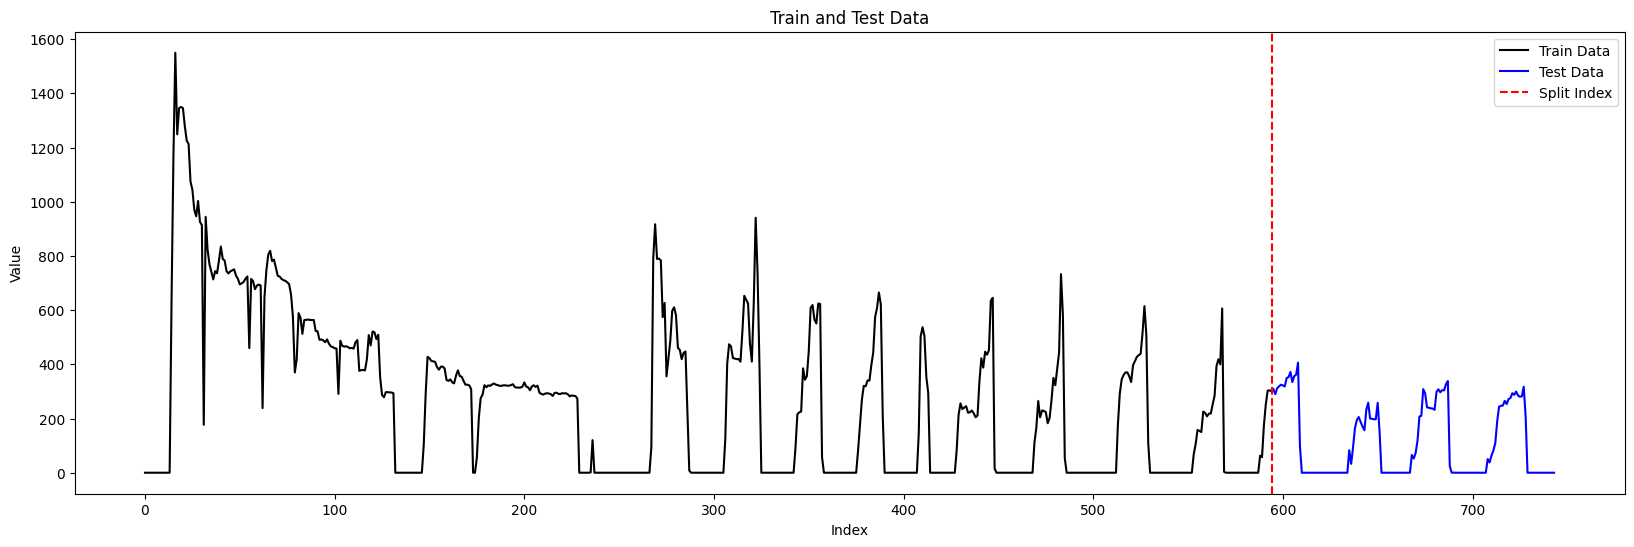

In [148]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [149]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [150]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [151]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [152]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [153]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [154]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [155]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [156]:
# pip install optuna
!pip install optuna-integration


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [157]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [158]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [159]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('window_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [160]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-10-24 21:53:47,158] A new study created in memory with name: no-name-2325ae26-8c9e-4e28-8fce-6480580d9f57


In [161]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://96f0490e-c5e8-4b71-b06d-188d6b0fde65/assets


INFO:tensorflow:Assets written to: ram://96f0490e-c5e8-4b71-b06d-188d6b0fde65/assets
[I 2023-10-24 21:56:29,374] Trial 0 finished with value: 0.004771250765770674 and parameters: {'window_size': 58, 'n_lstm_layers': 7, 'lstm_units': 181, 'learning_rate': 0.005899564999099366}. Best is trial 0 with value: 0.004771250765770674.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://61709466-a3a7-42f6-9970-658bae62d5d1/assets


INFO:tensorflow:Assets written to: ram://61709466-a3a7-42f6-9970-658bae62d5d1/assets
[I 2023-10-24 22:02:55,667] Trial 1 finished with value: 0.026736175641417503 and parameters: {'window_size': 12, 'n_lstm_layers': 13, 'lstm_units': 55, 'learning_rate': 0.0019872286478245117}. Best is trial 0 with value: 0.004771250765770674.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://2f34ffa5-7755-4699-b384-121d372de56b/assets


INFO:tensorflow:Assets written to: ram://2f34ffa5-7755-4699-b384-121d372de56b/assets
[I 2023-10-24 22:04:29,862] Trial 2 finished with value: 0.0022514257580041885 and parameters: {'window_size': 58, 'n_lstm_layers': 5, 'lstm_units': 93, 'learning_rate': 0.004148097799931977}. Best is trial 2 with value: 0.0022514257580041885.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://538c52e5-3fb4-41ed-8d64-01684f8f4467/assets


INFO:tensorflow:Assets written to: ram://538c52e5-3fb4-41ed-8d64-01684f8f4467/assets
[I 2023-10-24 22:08:56,848] Trial 3 finished with value: 0.014336783438920975 and parameters: {'window_size': 41, 'n_lstm_layers': 12, 'lstm_units': 222, 'learning_rate': 0.0031377127625669674}. Best is trial 2 with value: 0.0022514257580041885.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://f433d52d-532d-4171-a612-2e37606af937/assets


INFO:tensorflow:Assets written to: ram://f433d52d-532d-4171-a612-2e37606af937/assets
[I 2023-10-24 22:13:06,978] Trial 4 finished with value: 0.01528076734393835 and parameters: {'window_size': 55, 'n_lstm_layers': 17, 'lstm_units': 92, 'learning_rate': 0.00479881617036653}. Best is trial 2 with value: 0.0022514257580041885.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:13:24,468] Trial 5 pruned. 


INFO:tensorflow:Assets written to: ram://e0c05d8b-ada8-4c0d-928e-4f6f13afa49d/assets


INFO:tensorflow:Assets written to: ram://e0c05d8b-ada8-4c0d-928e-4f6f13afa49d/assets
[I 2023-10-24 22:22:40,961] Trial 6 finished with value: 0.0014592405641451478 and parameters: {'window_size': 3, 'n_lstm_layers': 7, 'lstm_units': 33, 'learning_rate': 0.0011380286690689829}. Best is trial 6 with value: 0.0014592405641451478.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:22:55,294] Trial 7 pruned. 
[I 2023-10-24 22:23:17,435] Trial 8 pruned. 


INFO:tensorflow:Assets written to: ram://5fb10faa-0b19-404c-923c-683b694e81c9/assets


INFO:tensorflow:Assets written to: ram://5fb10faa-0b19-404c-923c-683b694e81c9/assets
[I 2023-10-24 22:25:18,879] Trial 9 finished with value: 0.0011826521949842572 and parameters: {'window_size': 7, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0002503757625712498}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:25:26,806] Trial 10 pruned. 


INFO:tensorflow:Assets written to: ram://eb7df1f5-44de-461c-9e5b-6ec6477ff366/assets


INFO:tensorflow:Assets written to: ram://eb7df1f5-44de-461c-9e5b-6ec6477ff366/assets
[I 2023-10-24 22:31:03,328] Trial 11 finished with value: 0.0012826747260987759 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 215, 'learning_rate': 0.0005208949511167984}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://f7069297-f522-4368-8c13-7b180c01eaa9/assets


INFO:tensorflow:Assets written to: ram://f7069297-f522-4368-8c13-7b180c01eaa9/assets
[I 2023-10-24 22:34:31,247] Trial 12 finished with value: 0.0012962559703737497 and parameters: {'window_size': 3, 'n_lstm_layers': 1, 'lstm_units': 216, 'learning_rate': 0.0004130449297855071}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:34:36,126] Trial 13 pruned. 
[I 2023-10-24 22:34:45,663] Trial 14 pruned. 


INFO:tensorflow:Assets written to: ram://2284c98d-8a8e-43c4-9928-80b3abd203d8/assets


INFO:tensorflow:Assets written to: ram://2284c98d-8a8e-43c4-9928-80b3abd203d8/assets
[I 2023-10-24 22:43:43,464] Trial 15 finished with value: 0.002277397084981203 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 237, 'learning_rate': 0.0020439230918568273}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://701f6cca-9248-4426-8683-abb409b21297/assets


INFO:tensorflow:Assets written to: ram://701f6cca-9248-4426-8683-abb409b21297/assets
[I 2023-10-24 22:45:15,159] Trial 16 finished with value: 0.0021237225737422705 and parameters: {'window_size': 11, 'n_lstm_layers': 1, 'lstm_units': 189, 'learning_rate': 0.001473370355471462}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:45:21,693] Trial 17 pruned. 
[I 2023-10-24 22:45:30,387] Trial 18 pruned. 
[I 2023-10-24 22:45:34,265] Trial 19 pruned. 
[I 2023-1

INFO:tensorflow:Assets written to: ram://e4c76bb4-11a7-4779-b961-ef6ee74f048a/assets


INFO:tensorflow:Assets written to: ram://e4c76bb4-11a7-4779-b961-ef6ee74f048a/assets
[I 2023-10-24 22:48:21,132] Trial 21 finished with value: 0.001628189580515027 and parameters: {'window_size': 5, 'n_lstm_layers': 1, 'lstm_units': 220, 'learning_rate': 0.0008620919103463706}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:48:25,807] Trial 22 pruned. 


INFO:tensorflow:Assets written to: ram://e4b2a4c0-ca19-4699-b104-0037a802d482/assets


INFO:tensorflow:Assets written to: ram://e4b2a4c0-ca19-4699-b104-0037a802d482/assets
[I 2023-10-24 22:49:43,464] Trial 23 finished with value: 0.00241870922036469 and parameters: {'window_size': 15, 'n_lstm_layers': 1, 'lstm_units': 205, 'learning_rate': 0.001137681676916569}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://69ce7266-588b-429d-b925-9e17bbacd931/assets


INFO:tensorflow:Assets written to: ram://69ce7266-588b-429d-b925-9e17bbacd931/assets
[I 2023-10-24 22:58:48,417] Trial 24 finished with value: 0.002363451523706317 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 255, 'learning_rate': 0.002279377833028533}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 22:58:54,327] Trial 25 pruned. 
[I 2023-10-24 22:58:58,044] Trial 26 pruned. 
[I 2023-10-24 22:59:03,778] Trial 27 pruned. 
[I 2023-10-

INFO:tensorflow:Assets written to: ram://ab6f6050-e5d4-4b15-a965-6f0421a352b3/assets


INFO:tensorflow:Assets written to: ram://ab6f6050-e5d4-4b15-a965-6f0421a352b3/assets
[I 2023-10-24 23:10:44,098] Trial 36 finished with value: 0.002833781996741891 and parameters: {'window_size': 2, 'n_lstm_layers': 4, 'lstm_units': 151, 'learning_rate': 0.001321046176623139}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:10:58,422] Trial 37 pruned. 
[I 2023-10-24 23:11:09,633] Trial 38 pruned. 
[I 2023-10-24 23:11:15,715] Trial 39 pruned. 
[I 2023-10-

INFO:tensorflow:Assets written to: ram://4030aa17-b8de-4b37-b084-c282d60f46ea/assets


INFO:tensorflow:Assets written to: ram://4030aa17-b8de-4b37-b084-c282d60f46ea/assets
[I 2023-10-24 23:14:13,329] Trial 41 finished with value: 0.00162341701798141 and parameters: {'window_size': 5, 'n_lstm_layers': 1, 'lstm_units': 227, 'learning_rate': 0.0005596930449453818}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:14:16,738] Trial 42 pruned. 


INFO:tensorflow:Assets written to: ram://7258f88c-47dd-4b5c-9609-1fe6c6ac42a9/assets


INFO:tensorflow:Assets written to: ram://7258f88c-47dd-4b5c-9609-1fe6c6ac42a9/assets
[I 2023-10-24 23:16:51,154] Trial 43 finished with value: 0.0014884884003549814 and parameters: {'window_size': 5, 'n_lstm_layers': 1, 'lstm_units': 240, 'learning_rate': 0.0004433632759135802}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:16:54,980] Trial 44 pruned. 
[I 2023-10-24 23:17:00,296] Trial 45 pruned. 
[I 2023-10-24 23:17:02,393] Trial 46 pruned. 
[I 2023-1

INFO:tensorflow:Assets written to: ram://8f807933-4b52-40f2-b247-4451ef045ffd/assets


INFO:tensorflow:Assets written to: ram://8f807933-4b52-40f2-b247-4451ef045ffd/assets
[I 2023-10-24 23:23:12,473] Trial 50 finished with value: 0.001421082648448646 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.0012913941143905153}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://20f5e560-6bc2-4018-8c44-6e365c4fbea2/assets


INFO:tensorflow:Assets written to: ram://20f5e560-6bc2-4018-8c44-6e365c4fbea2/assets
[I 2023-10-24 23:26:23,765] Trial 51 finished with value: 0.0012996591394767165 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.0012135053748940532}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://0db3fad7-6160-482f-9247-332c88725502/assets


INFO:tensorflow:Assets written to: ram://0db3fad7-6160-482f-9247-332c88725502/assets
[I 2023-10-24 23:33:48,008] Trial 52 finished with value: 0.0022568455897271633 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 229, 'learning_rate': 0.0012378976909329172}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:33:52,887] Trial 53 pruned. 


INFO:tensorflow:Assets written to: ram://997eb08d-eb03-4b73-9fbd-a210c2d2414f/assets


INFO:tensorflow:Assets written to: ram://997eb08d-eb03-4b73-9fbd-a210c2d2414f/assets
[I 2023-10-24 23:35:55,031] Trial 54 finished with value: 0.0016275739762932062 and parameters: {'window_size': 7, 'n_lstm_layers': 1, 'lstm_units': 209, 'learning_rate': 0.001759533777539992}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:36:00,065] Trial 55 pruned. 


INFO:tensorflow:Assets written to: ram://befafa9f-e81d-43f4-b799-18e59a5073a4/assets


INFO:tensorflow:Assets written to: ram://befafa9f-e81d-43f4-b799-18e59a5073a4/assets
[I 2023-10-24 23:40:09,564] Trial 56 finished with value: 0.0013635108480229974 and parameters: {'window_size': 4, 'n_lstm_layers': 2, 'lstm_units': 236, 'learning_rate': 0.0014063479780681157}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:40:13,081] Trial 57 pruned. 


INFO:tensorflow:Assets written to: ram://c0b0b1a0-cd75-4c5c-991e-1d9ccce5d8c6/assets


INFO:tensorflow:Assets written to: ram://c0b0b1a0-cd75-4c5c-991e-1d9ccce5d8c6/assets
[I 2023-10-24 23:42:29,506] Trial 58 finished with value: 0.0017422017408534884 and parameters: {'window_size': 6, 'n_lstm_layers': 1, 'lstm_units': 221, 'learning_rate': 0.002142389670958964}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://4ab0c9fa-f414-45e5-858e-c025bcb94280/assets


INFO:tensorflow:Assets written to: ram://4ab0c9fa-f414-45e5-858e-c025bcb94280/assets
[I 2023-10-24 23:51:23,400] Trial 59 finished with value: 0.0015688244020566344 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 244, 'learning_rate': 0.0008535796544903578}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:51:26,595] Trial 60 pruned. 
[I 2023-10-24 23:51:30,614] Trial 61 pruned. 
[I 2023-10-24 23:51:35,445] Trial 62 pruned. 
[I 2023-1

INFO:tensorflow:Assets written to: ram://59af4f7c-ad3a-4b2e-ba71-d0b681d93d85/assets


INFO:tensorflow:Assets written to: ram://59af4f7c-ad3a-4b2e-ba71-d0b681d93d85/assets
[I 2023-10-24 23:54:11,767] Trial 72 finished with value: 0.002266140189021826 and parameters: {'window_size': 9, 'n_lstm_layers': 1, 'lstm_units': 244, 'learning_rate': 0.0014301473122628027}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-24 23:54:15,371] Trial 73 pruned. 
[I 2023-10-24 23:54:33,164] Trial 74 pruned. 
[I 2023-10-24 23:54:44,179] Trial 75 pruned. 
[I 2023-10

INFO:tensorflow:Assets written to: ram://a7089de0-2cdd-4e7a-95ca-ccdb5148c898/assets


INFO:tensorflow:Assets written to: ram://a7089de0-2cdd-4e7a-95ca-ccdb5148c898/assets
[I 2023-10-25 00:02:45,411] Trial 82 finished with value: 0.0018489767098799348 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 250, 'learning_rate': 0.0009187801233966185}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 00:02:49,724] Trial 83 pruned. 
[I 2023-10-25 00:02:52,039] Trial 84 pruned. 
[I 2023-10-25 00:02:55,463] Trial 85 pruned. 
[I 2023-1

INFO:tensorflow:Assets written to: ram://01649339-47d8-475f-b7eb-7a8c88f96fd0/assets


INFO:tensorflow:Assets written to: ram://01649339-47d8-475f-b7eb-7a8c88f96fd0/assets
[I 2023-10-25 00:06:03,076] Trial 104 finished with value: 0.0016714234370738268 and parameters: {'window_size': 7, 'n_lstm_layers': 1, 'lstm_units': 237, 'learning_rate': 0.00150356939354373}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 00:06:07,236] Trial 105 pruned. 
[I 2023-10-25 00:06:11,081] Trial 106 pruned. 


INFO:tensorflow:Assets written to: ram://8d79ff37-2a16-4a47-a7ed-d02a3135b897/assets


INFO:tensorflow:Assets written to: ram://8d79ff37-2a16-4a47-a7ed-d02a3135b897/assets
[I 2023-10-25 00:17:52,537] Trial 107 finished with value: 0.0021645070519298315 and parameters: {'window_size': 2, 'n_lstm_layers': 5, 'lstm_units': 208, 'learning_rate': 0.000902044229600256}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 00:18:07,032] Trial 108 pruned. 
[I 2023-10-25 00:18:10,707] Trial 109 pruned. 
[I 2023-10-25 00:18:14,803] Trial 110 pruned. 


INFO:tensorflow:Assets written to: ram://e8578fb4-574c-4312-b057-a697cc9e8624/assets


INFO:tensorflow:Assets written to: ram://e8578fb4-574c-4312-b057-a697cc9e8624/assets
[I 2023-10-25 00:21:27,905] Trial 111 finished with value: 0.0013010714901611209 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.0011103743919309648}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 00:21:31,059] Trial 112 pruned. 
[I 2023-10-25 00:21:36,205] Trial 113 pruned. 


INFO:tensorflow:Assets written to: ram://aa1fec05-e5a7-4820-a702-816c80db0483/assets


INFO:tensorflow:Assets written to: ram://aa1fec05-e5a7-4820-a702-816c80db0483/assets
[I 2023-10-25 00:28:56,780] Trial 114 finished with value: 0.0014244512422010303 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 236, 'learning_rate': 0.0004963731835554873}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://69c181d4-22a2-441d-82ab-ece03ad36bec/assets


INFO:tensorflow:Assets written to: ram://69c181d4-22a2-441d-82ab-ece03ad36bec/assets
[I 2023-10-25 00:36:24,059] Trial 115 finished with value: 0.0013772655511274934 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 251, 'learning_rate': 0.00042816915466604175}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://1984c799-6385-4dba-a74a-b7d9d1af8f98/assets


INFO:tensorflow:Assets written to: ram://1984c799-6385-4dba-a74a-b7d9d1af8f98/assets
[I 2023-10-25 00:43:45,354] Trial 116 finished with value: 0.0013987207785248756 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 252, 'learning_rate': 0.00044916444980614795}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://77da6dcd-1b4d-4e76-b419-266e9d8f972a/assets


INFO:tensorflow:Assets written to: ram://77da6dcd-1b4d-4e76-b419-266e9d8f972a/assets
[I 2023-10-25 00:51:18,873] Trial 117 finished with value: 0.001404555281624198 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 253, 'learning_rate': 0.0004795453629243029}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://048f6d10-68e5-48e7-b2f8-4a07904507c9/assets


INFO:tensorflow:Assets written to: ram://048f6d10-68e5-48e7-b2f8-4a07904507c9/assets
[I 2023-10-25 01:02:15,164] Trial 118 finished with value: 0.0016147372080013156 and parameters: {'window_size': 2, 'n_lstm_layers': 4, 'lstm_units': 251, 'learning_rate': 0.0004884923855487788}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 01:02:19,561] Trial 119 pruned. 
[I 2023-10-25 01:02:33,463] Trial 120 pruned. 
[I 2023-10-25 01:02:37,264] Trial 121 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://dfcc7341-51c0-4b47-a939-0b69602d985e/assets


INFO:tensorflow:Assets written to: ram://dfcc7341-51c0-4b47-a939-0b69602d985e/assets
[I 2023-10-25 01:05:46,714] Trial 123 finished with value: 0.001281602424569428 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0010812624608628385}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://85869f87-4296-46b7-ab88-db6edcbf8436/assets


INFO:tensorflow:Assets written to: ram://85869f87-4296-46b7-ab88-db6edcbf8436/assets
[I 2023-10-25 01:08:59,242] Trial 124 finished with value: 0.0013064290396869183 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 253, 'learning_rate': 0.0010364292125543508}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://9cde0b67-c529-48ae-8333-1438aa59204e/assets


INFO:tensorflow:Assets written to: ram://9cde0b67-c529-48ae-8333-1438aa59204e/assets
[I 2023-10-25 01:12:07,111] Trial 125 finished with value: 0.001310670399107039 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 253, 'learning_rate': 0.0010187700042012336}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://a914f1ec-9047-4063-9cf3-d45505129143/assets


INFO:tensorflow:Assets written to: ram://a914f1ec-9047-4063-9cf3-d45505129143/assets
[I 2023-10-25 01:15:20,767] Trial 126 finished with value: 0.0013000918552279472 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 254, 'learning_rate': 0.0010262102009939594}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://393a56a0-fff7-48f6-ab78-4eb5e90f99d2/assets


INFO:tensorflow:Assets written to: ram://393a56a0-fff7-48f6-ab78-4eb5e90f99d2/assets
[I 2023-10-25 01:18:29,268] Trial 127 finished with value: 0.001286829705350101 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 253, 'learning_rate': 0.0010835046633719838}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 01:18:32,162] Trial 128 pruned. 
[I 2023-10-25 01:18:34,852] Trial 129 pruned. 
[I 2023-10-25 01:18:37,167] Trial 130 pruned. 
[I 202

INFO:tensorflow:Assets written to: ram://800e4e87-7415-46d4-b421-e92c12c37a8d/assets


INFO:tensorflow:Assets written to: ram://800e4e87-7415-46d4-b421-e92c12c37a8d/assets
[I 2023-10-25 01:24:47,769] Trial 141 finished with value: 0.0014185047475621104 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.0014622363630289667}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://9f82e905-3d02-4efd-8f55-efbdfeeaca13/assets


INFO:tensorflow:Assets written to: ram://9f82e905-3d02-4efd-8f55-efbdfeeaca13/assets
[I 2023-10-25 01:30:28,676] Trial 142 finished with value: 0.0014242404140532017 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.0014161443247759989}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 01:30:32,403] Trial 143 pruned. 
[I 2023-10-25 01:30:36,281] Trial 144 pruned. 
[I 2023-10-25 01:30:41,362] Trial 145 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://6093e417-b824-4dfb-948e-b2fe1aea99ec/assets


INFO:tensorflow:Assets written to: ram://6093e417-b824-4dfb-948e-b2fe1aea99ec/assets
[I 2023-10-25 01:36:33,585] Trial 151 finished with value: 0.001467213616706431 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 238, 'learning_rate': 0.0013870658978152874}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://82b9c932-78e8-4b78-9a0e-53c7b71cce1c/assets


INFO:tensorflow:Assets written to: ram://82b9c932-78e8-4b78-9a0e-53c7b71cce1c/assets
[I 2023-10-25 01:42:01,423] Trial 152 finished with value: 0.001414735452271998 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.0010019598269630056}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 01:42:05,491] Trial 153 pruned. 


INFO:tensorflow:Assets written to: ram://fb181d6f-e9f0-4235-9765-3a9f43e70ee1/assets


INFO:tensorflow:Assets written to: ram://fb181d6f-e9f0-4235-9765-3a9f43e70ee1/assets
[I 2023-10-25 01:47:45,112] Trial 154 finished with value: 0.0014118424151092768 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0010135687094890557}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 01:47:47,631] Trial 155 pruned. 
[I 2023-10-25 01:47:51,181] Trial 156 pruned. 
[I 2023-10-25 01:47:55,278] Trial 157 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://f03d6b32-b25f-4a1a-bdcc-8aae36d70371/assets


INFO:tensorflow:Assets written to: ram://f03d6b32-b25f-4a1a-bdcc-8aae36d70371/assets
[I 2023-10-25 01:55:20,500] Trial 160 finished with value: 0.0013738888083025813 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 244, 'learning_rate': 0.0003896138522114119}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://2706bd35-5035-4aae-9ebd-73ea518f8b99/assets


INFO:tensorflow:Assets written to: ram://2706bd35-5035-4aae-9ebd-73ea518f8b99/assets
[I 2023-10-25 02:02:41,623] Trial 161 finished with value: 0.0013487491523846984 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 244, 'learning_rate': 0.00034973722189830055}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:02:44,913] Trial 162 pruned. 


INFO:tensorflow:Assets written to: ram://a2963584-c9be-4848-a47e-064a091625db/assets


INFO:tensorflow:Assets written to: ram://a2963584-c9be-4848-a47e-064a091625db/assets
[I 2023-10-25 02:11:52,781] Trial 163 finished with value: 0.0014156651450321078 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 246, 'learning_rate': 0.0003809778911105896}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:11:56,300] Trial 164 pruned. 
[I 2023-10-25 02:11:58,910] Trial 165 pruned. 
[I 2023-10-25 02:12:03,620] Trial 166 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://fc1128ee-4644-4aae-83fc-8c5b38deb641/assets


INFO:tensorflow:Assets written to: ram://fc1128ee-4644-4aae-83fc-8c5b38deb641/assets
[I 2023-10-25 02:17:44,688] Trial 169 finished with value: 0.0013767335331067443 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0008462157633256793}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:17:47,035] Trial 170 pruned. 
[I 2023-10-25 02:17:51,290] Trial 171 pruned. 
[I 2023-10-25 02:17:53,965] Trial 172 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://1fbb7fd0-9da1-455c-8497-6e4a82cac98d/assets


INFO:tensorflow:Assets written to: ram://1fbb7fd0-9da1-455c-8497-6e4a82cac98d/assets
[I 2023-10-25 02:23:48,368] Trial 178 finished with value: 0.0013010286493226886 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.000555798509753281}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:23:59,031] Trial 179 pruned. 
[I 2023-10-25 02:24:01,332] Trial 180 pruned. 


INFO:tensorflow:Assets written to: ram://65fd2531-42f4-4a18-a585-71cff875e3a7/assets


INFO:tensorflow:Assets written to: ram://65fd2531-42f4-4a18-a585-71cff875e3a7/assets
[I 2023-10-25 02:29:37,629] Trial 181 finished with value: 0.0013967272825539112 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.000906777438104336}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:29:41,687] Trial 182 pruned. 
[I 2023-10-25 02:29:44,865] Trial 183 pruned. 
[I 2023-10-25 02:29:48,210] Trial 184 pruned. 
[I 202

INFO:tensorflow:Assets written to: ram://75763bc0-734d-4f78-9165-75dcebc29386/assets


INFO:tensorflow:Assets written to: ram://75763bc0-734d-4f78-9165-75dcebc29386/assets
[I 2023-10-25 02:35:45,481] Trial 191 finished with value: 0.0014040590031072497 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0010062181917260618}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://a4e1af56-29a2-4958-a603-48666b878c05/assets


INFO:tensorflow:Assets written to: ram://a4e1af56-29a2-4958-a603-48666b878c05/assets
[I 2023-10-25 02:41:24,493] Trial 192 finished with value: 0.0014083965215831995 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0010182623050982648}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:41:28,259] Trial 193 pruned. 
[I 2023-10-25 02:41:32,137] Trial 194 pruned. 


INFO:tensorflow:Assets written to: ram://f8c4e583-87f9-489f-952f-4c64789c9963/assets


INFO:tensorflow:Assets written to: ram://f8c4e583-87f9-489f-952f-4c64789c9963/assets
[I 2023-10-25 02:47:10,946] Trial 195 finished with value: 0.0014052846236154437 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 243, 'learning_rate': 0.0012116794074519968}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:47:14,419] Trial 196 pruned. 
[I 2023-10-25 02:47:16,967] Trial 197 pruned. 
[I 2023-10-25 02:47:20,470] Trial 198 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://bb818d10-7411-43bb-bac1-7ebcdab6b3a7/assets


INFO:tensorflow:Assets written to: ram://bb818d10-7411-43bb-bac1-7ebcdab6b3a7/assets
[I 2023-10-25 02:53:31,146] Trial 202 finished with value: 0.0014673807891085744 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0014748262256605164}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 02:53:35,150] Trial 203 pruned. 
[I 2023-10-25 02:53:40,530] Trial 204 pruned. 
[I 2023-10-25 02:53:44,204] Trial 205 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://134be46a-8282-4e77-aa99-6b151da99196/assets


INFO:tensorflow:Assets written to: ram://134be46a-8282-4e77-aa99-6b151da99196/assets
[I 2023-10-25 02:59:56,317] Trial 211 finished with value: 0.0014020416419953108 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.0010326109689350283}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://28f78cc8-1c93-4c93-859a-ae766b1c1ad7/assets


INFO:tensorflow:Assets written to: ram://28f78cc8-1c93-4c93-859a-ae766b1c1ad7/assets
[I 2023-10-25 03:05:37,490] Trial 212 finished with value: 0.0014151771320030093 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.0010907617960315423}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:05:40,094] Trial 213 pruned. 


INFO:tensorflow:Assets written to: ram://7e4ab467-3ace-4184-b1b1-cd492b0e0b75/assets


INFO:tensorflow:Assets written to: ram://7e4ab467-3ace-4184-b1b1-cd492b0e0b75/assets
[I 2023-10-25 03:11:21,572] Trial 214 finished with value: 0.0014395227190107107 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 243, 'learning_rate': 0.0015517524774548107}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:11:25,105] Trial 215 pruned. 
[I 2023-10-25 03:11:27,453] Trial 216 pruned. 
[I 2023-10-25 03:11:30,347] Trial 217 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://cfd37c52-83e4-4c18-974e-ccbf7f18592a/assets


INFO:tensorflow:Assets written to: ram://cfd37c52-83e4-4c18-974e-ccbf7f18592a/assets
[I 2023-10-25 03:17:14,931] Trial 219 finished with value: 0.0014123161090537906 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 253, 'learning_rate': 0.0010871121636533937}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:17:18,495] Trial 220 pruned. 


INFO:tensorflow:Assets written to: ram://d25e71f8-c08b-4c38-a0b7-e9025318e3de/assets


INFO:tensorflow:Assets written to: ram://d25e71f8-c08b-4c38-a0b7-e9025318e3de/assets
[I 2023-10-25 03:22:59,556] Trial 221 finished with value: 0.0014108867617323995 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 247, 'learning_rate': 0.0010048824955507657}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://ad7b4008-a69c-45a8-baf0-4520307d3f6c/assets


INFO:tensorflow:Assets written to: ram://ad7b4008-a69c-45a8-baf0-4520307d3f6c/assets
[I 2023-10-25 03:28:41,291] Trial 222 finished with value: 0.0013536644401028752 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 177, 'learning_rate': 0.0008186545604908323}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:28:43,792] Trial 223 pruned. 
[I 2023-10-25 03:28:46,233] Trial 224 pruned. 


INFO:tensorflow:Assets written to: ram://f2f8883c-e370-4e7b-a30b-520685dcd613/assets


INFO:tensorflow:Assets written to: ram://f2f8883c-e370-4e7b-a30b-520685dcd613/assets
[I 2023-10-25 03:36:11,351] Trial 225 finished with value: 0.001510279718786478 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 199, 'learning_rate': 0.0008541106819589233}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:36:14,229] Trial 226 pruned. 
[I 2023-10-25 03:36:17,638] Trial 227 pruned. 


INFO:tensorflow:Assets written to: ram://646e188f-2213-42b9-83c7-eb70e847d9ab/assets


INFO:tensorflow:Assets written to: ram://646e188f-2213-42b9-83c7-eb70e847d9ab/assets
[I 2023-10-25 03:41:59,052] Trial 228 finished with value: 0.0014206691412255168 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 243, 'learning_rate': 0.001177159177378857}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:42:01,738] Trial 229 pruned. 
[I 2023-10-25 03:42:04,786] Trial 230 pruned. 


INFO:tensorflow:Assets written to: ram://c40a98ac-3e01-47b0-ac14-51bc8f751836/assets


INFO:tensorflow:Assets written to: ram://c40a98ac-3e01-47b0-ac14-51bc8f751836/assets
[I 2023-10-25 03:47:45,069] Trial 231 finished with value: 0.0014065492432564497 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.0009905720279675993}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://ca076df1-66f8-4277-b3ce-bc76aeb37b11/assets


INFO:tensorflow:Assets written to: ram://ca076df1-66f8-4277-b3ce-bc76aeb37b11/assets
[I 2023-10-25 03:53:22,918] Trial 232 finished with value: 0.0014077604282647371 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.0010228112581572766}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:53:25,279] Trial 233 pruned. 
[I 2023-10-25 03:53:27,811] Trial 234 pruned. 


INFO:tensorflow:Assets written to: ram://89026a07-f11c-484d-94c1-2648935e0e6a/assets


INFO:tensorflow:Assets written to: ram://89026a07-f11c-484d-94c1-2648935e0e6a/assets
[I 2023-10-25 03:58:57,883] Trial 235 finished with value: 0.0013961652293801308 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.0009864263001425667}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 03:59:01,624] Trial 236 pruned. 
[I 2023-10-25 03:59:03,798] Trial 237 pruned. 
[I 2023-10-25 03:59:07,364] Trial 238 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://52ce8cb1-8234-4da1-8138-ca06338a4bc0/assets


INFO:tensorflow:Assets written to: ram://52ce8cb1-8234-4da1-8138-ca06338a4bc0/assets
[I 2023-10-25 04:04:49,346] Trial 240 finished with value: 0.0012946309288963675 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.0005395625894153155}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 04:04:52,317] Trial 241 pruned. 
[I 2023-10-25 04:04:55,070] Trial 242 pruned. 
[I 2023-10-25 04:04:57,978] Trial 243 pruned. 
[I 20

INFO:tensorflow:Assets written to: ram://5058435b-69ba-4145-a275-e45255d2df40/assets


INFO:tensorflow:Assets written to: ram://5058435b-69ba-4145-a275-e45255d2df40/assets
[I 2023-10-25 04:10:43,897] Trial 246 finished with value: 0.001246731379069388 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 248, 'learning_rate': 0.0004561575797340392}. Best is trial 9 with value: 0.0011826521949842572.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 04:10:47,398] Trial 247 pruned. 
[I 2023-10-25 04:10:50,105] Trial 248 pruned. 
[I 2023-10-25 04:10:52,983] Trial 249 pruned. 


In [162]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 7, 'n_lstm_layers': 1, 'lstm_units': 249, 'learning_rate': 0.0002503757625712498}
Best Validation Loss: 0.0011826521949842572


In [163]:
study.best_params['n_lstm_layers']

1

In [164]:
study.best_trial.number

9

In [165]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['window_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [166]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 0s/step


In [167]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.003411559551397689
Test MSE: 0.0011611818500201635


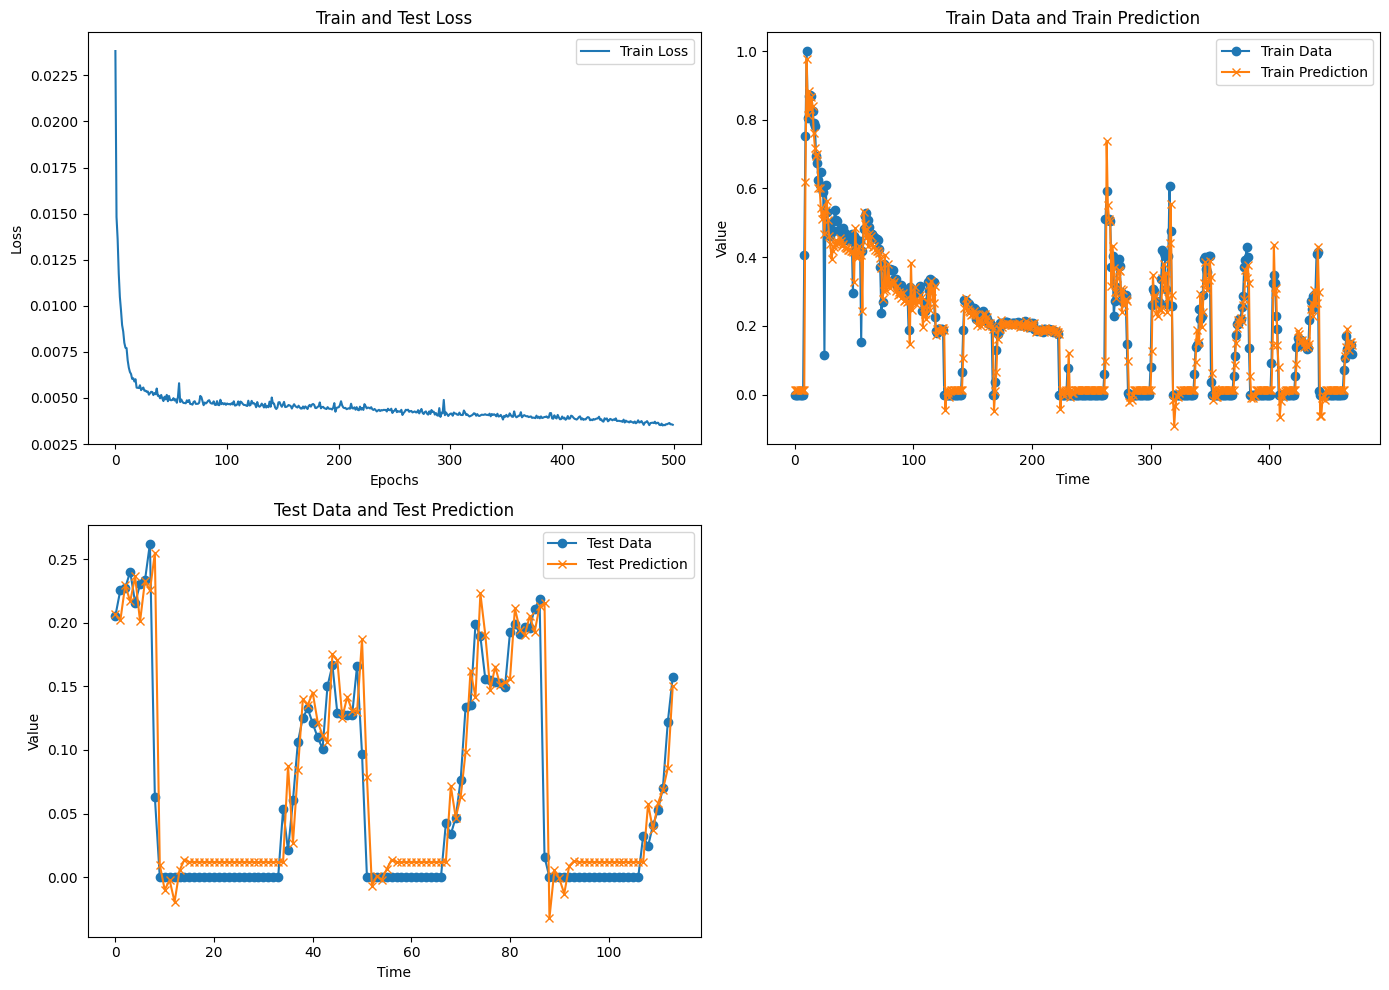

In [168]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

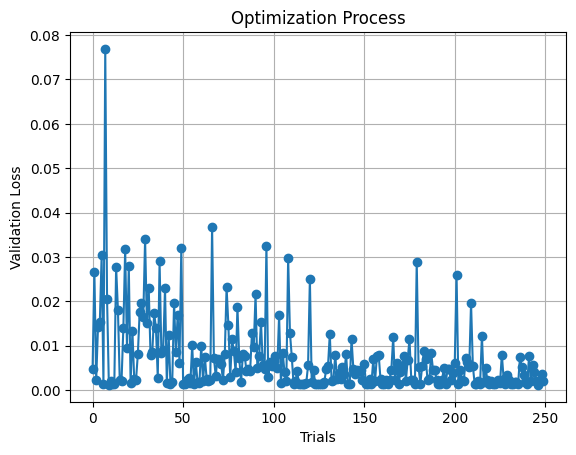

In [169]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

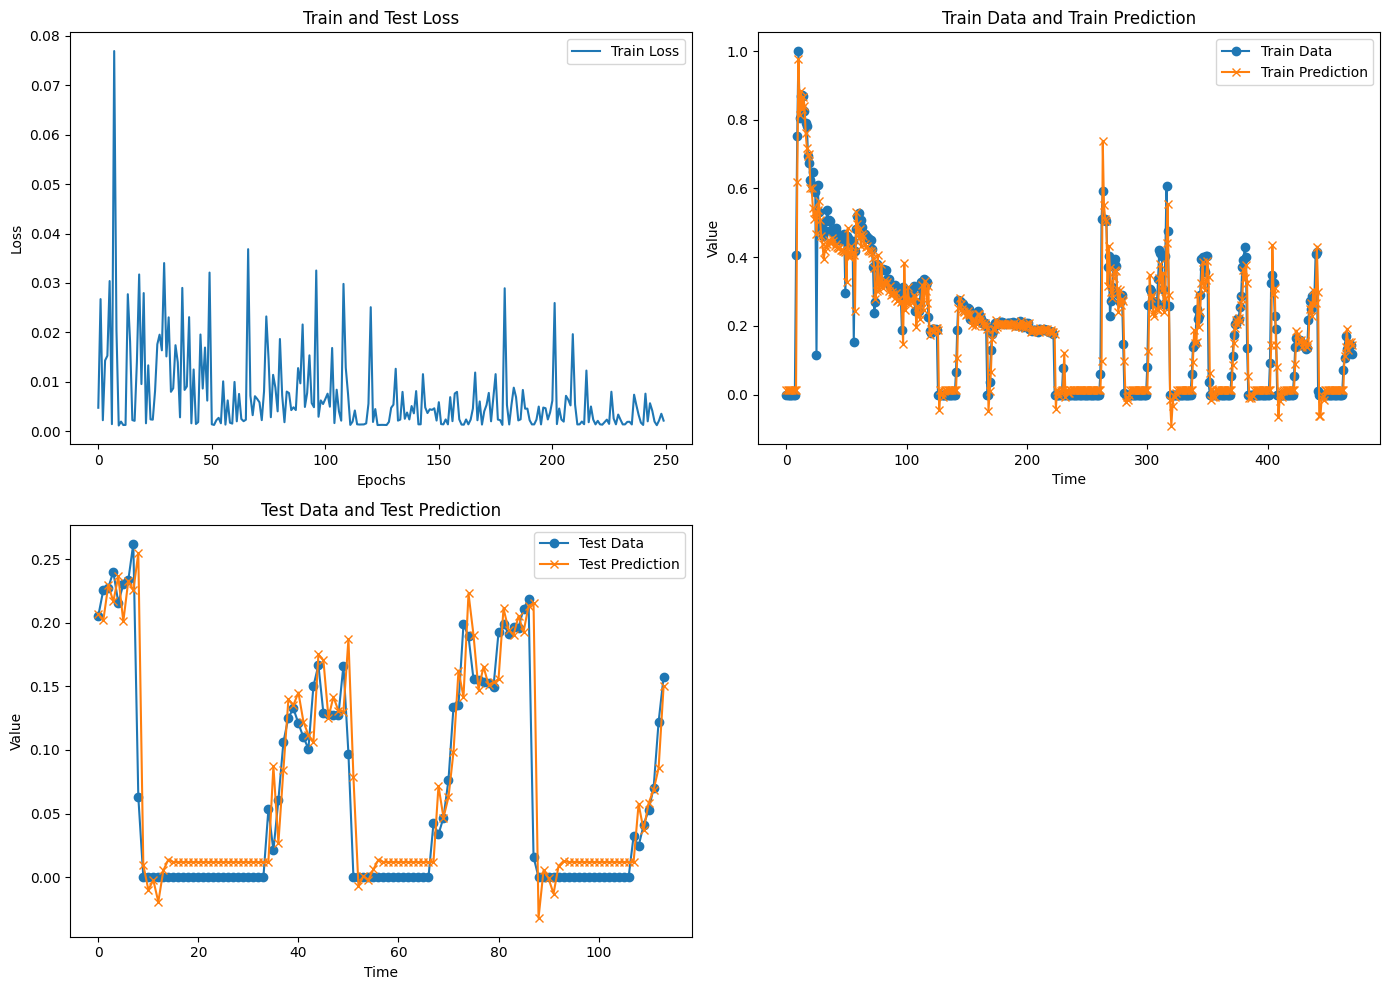

In [170]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [171]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [172]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [173]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [174]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [175]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [176]:
# from keras.utils.vis_utils import plot_model


In [177]:
# plot_model(model_LSTM)

In [178]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [179]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [180]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.005420298548920658
Test MSE: 0.0015503941610013052


In [181]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [182]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.003412  0.001161
1  Baseline   0.005420  0.001550


In [183]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [184]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 58, 'n_lstm_layers': 7, 'lstm_units': 181, 'learning_rate': 0.005899564999099366}
Trial 2: {'window_size': 12, 'n_lstm_layers': 13, 'lstm_units': 55, 'learning_rate': 0.0019872286478245117}
Trial 3: {'window_size': 58, 'n_lstm_layers': 5, 'lstm_units': 93, 'learning_rate': 0.004148097799931977}
Trial 4: {'window_size': 41, 'n_lstm_layers': 12, 'lstm_units': 222, 'learning_rate': 0.0031377127625669674}
Trial 5: {'window_size': 55, 'n_lstm_layers': 17, 'lstm_units': 92, 'learning_rate': 0.00479881617036653}
Trial 6: {'window_size': 17, 'n_lstm_layers': 16, 'lstm_units': 51, 'learning_rate': 0.006264533758473043}
Trial 7: {'window_size': 3, 'n_lstm_layers': 7, 'lstm_units': 33, 'learning_rate': 0.0011380286690689829}
Trial 8: {'window_size': 41, 'n_lstm_layers': 14, 'lstm_units': 138, 'learning_rate': 0.006563039590984539}
Trial 9: {'window_size': 20, 'n_lstm_layers': 20, 'lstm_units': 163, 'learning_rate': 0.0097969873386